<a href="https://colab.research.google.com/github/touQerabaS/Named-Entity-Recognition-With-LSTM/blob/main/a2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Named Entity Recognition (NER)


In this work, you will build a named entity recognition system based on GRU and LSTM. 


 - (10%) Download the dataset (use ner_dataset) and conduct the appropriate preprocessing steps.

 - (30%) Implement both GRU and LSTM on the dataset. Explain the architecture you employed for both algorithms. Divide the dataset into training, validation, and test set. Use the validation set to select the best learning rate. After the validation phase, combine the training and the validation sets and train your model on the combined set using the best learning rate.

 - (20%) Compare the performance of your models in terms of accuracy and F1 and training time, discuss your results.

 - You must write both algorithms in PyTorch.

You can download the dataset here at https://www.kaggle.com/shahad001/named-entity-recognition-ner

The link above also shows the appropriate steps you have to follow for preprocessing and preparing the data. 

### Check-In

Name your notebook Firstname-Lastname-A2.ipynb. Submit the file to my email address 

# Implmentation of LSTM and GRU

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)
#np.random.seed(0)
#plt.style.use("ggplot")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/My Drive/BERT/ner.csv",encoding='latin1',error_bad_lines=False)
data = data[['sentence_idx',"word","tag"]]
data = data.fillna(method="ffill")
data.head(5)

b'Skipping line 281837: expected 25 fields, saw 34\n'


,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [ ]:
data = data[:15000]

In [ ]:
len(data)

15000

In [ ]:
counter=[]
sentance_tages=[]
sentanc=[]
for sent_id,word,tag in zip(data['sentence_idx'].values,data['word'].values,data['tag'].values):
    if sent_id not in counter:
        counter.append(sent_id)
        sentance_tages.append(sentanc)
        sentanc=[]
        sentanc.append((word,tag))
    else:
        sentanc.append((word,tag))
sentance_tages

[[],
 [('Thousands', 'O'),
  ('of', 'O'),
  ('demonstrators', 'O'),
  ('have', 'O'),
  ('marched', 'O'),
  ('through', 'O'),
  ('London', 'B-geo'),
  ('to', 'O'),
  ('protest', 'O'),
  ('the', 'O'),
  ('war', 'O'),
  ('in', 'O'),
  ('Iraq', 'B-geo'),
  ('and', 'O'),
  ('demand', 'O'),
  ('the', 'O'),
  ('withdrawal', 'O'),
  ('of', 'O'),
  ('British', 'B-gpe'),
  ('troops', 'O'),
  ('from', 'O'),
  ('that', 'O'),
  ('country', 'O'),
  ('.', 'O')],
 [('Families', 'O'),
  ('of', 'O'),
  ('soldiers', 'O'),
  ('killed', 'O'),
  ('in', 'O'),
  ('the', 'O'),
  ('conflict', 'O'),
  ('joined', 'O'),
  ('the', 'O'),
  ('protesters', 'O'),
  ('who', 'O'),
  ('carried', 'O'),
  ('banners', 'O'),
  ('with', 'O'),
  ('such', 'O'),
  ('slogans', 'O'),
  ('as', 'O'),
  ('"', 'O'),
  ('Bush', 'B-per'),
  ('Number', 'O'),
  ('One', 'O'),
  ('Terrorist', 'O'),
  ('"', 'O'),
  ('and', 'O'),
  ('"', 'O'),
  ('Stop', 'O'),
  ('the', 'O'),
  ('Bombings', 'O'),
  ('.', 'O'),
  ('"', 'O')],
 [('They', 'O'),
 

In [ ]:
words = set(list(data['word'].values))
words.add('PADword')
n_words = len(words)
n_words

3597

In [ ]:
tags = list(set(data["tag"].values))
n_tags = len(tags)
n_tags

17

In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)

In [ ]:
word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
tagged_sentence = sentance_tages
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 3594
Unique tags: 17
Unique characters: 77


In [ ]:
import random

tr_random = random.sample(list(range(len(tagged_sentence))), int(0.95 * len(tagged_sentence)))

train = [tagged_sentence[i] for i in tr_random]
test = [tagged_sentence[i] for i in range(len(tagged_sentence)) if i not in tr_random]

In [ ]:
WORD_EMBEDDING_DIM = 32
CHAR_EMBEDDING_DIM = 4
WORD_HIDDEN_DIM = 32
CHAR_HIDDEN_DIM = 32
EPOCHS = 2

In [ ]:
class DualLSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, word_hidden_dim, char_embedding_dim, char_hidden_dim, word_vocab_size, char_vocab_size, tag_vocab_size):
        super(DualLSTMTagger, self).__init__()
        self.word_embedding = nn.Embedding(word_vocab_size, word_embedding_dim)
        
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        self.char_lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
        
        self.lstm = nn.LSTM(word_embedding_dim + char_hidden_dim, word_hidden_dim)
        self.hidden2tag = nn.Linear(word_hidden_dim, tag_vocab_size)
        
    def forward(self, sentence, words):
        embeds = self.word_embedding(sentence)
        char_hidden_final = []
        for word in words:
            char_embeds = self.char_embedding(word)
            _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds.view(len(word), 1, -1))
            word_char_hidden_state = char_hidden.view(-1)
            char_hidden_final.append(word_char_hidden_state)
        char_hidden_final = torch.stack(tuple(char_hidden_final))
        
        combined = torch.cat((embeds, char_hidden_final), 1)

        lstm_out, _ = self.lstm(combined.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [ ]:
model = DualLSTMTagger(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_EMBEDDING_DIM, CHAR_HIDDEN_DIM, word_vocab_size, char_vocab_size, tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")


# Define the loss function as the Negative Log Likelihood loss (NLLLoss)
loss_function = nn.NLLLoss()

# We will be using a simple SGD optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# The test sentence
seq = "everybody eat the food . I kept looking out the window , trying to find the one I was waiting for .".split()
print("Running a check on the model before training.\nSentences:\n{}".format(" ".join(seq)))

# Training start
print("Training Started")
accuracy_list = []
loss_list = []
interval = round(len(train) / 100.)
epochs = EPOCHS
e_interval = 1
for epoch in range(epochs):
    acc = 0 #to keep track of accuracy
    loss = 0 # To keep track of the loss value
    i = 0
    for sentence_tag in train:
        i += 1
        words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long) for s in sentence_tag]
        sentence = [s[0] for s in sentence_tag]
        sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long)
        targets = [s[1] for s in sentence_tag]
        targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long)
        
        model.zero_grad()
        
        tag_scores = model(sentence, words)
        
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        _, indices = torch.max(tag_scores, 1)
#         print(indices == targets)
        acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
        if i % interval == 0:
            print("Epoch {} Running;\t{}% Complete".format(epoch + 1, i / interval), end = "\r", flush = True)
    loss = loss / len(train)
    acc = acc / len(train)
    loss_list.append(float(loss))
    accuracy_list.append(float(acc))
    if (epoch + 1) % e_interval == 0:
        print("Epoch {} Completed,\tLoss {}\tAccuracy: {}".format(epoch + 1, np.mean(loss_list[-e_interval:]), np.mean(accuracy_list[-e_interval:])))


Running a check on the model before training.
Sentences:
everybody eat the food . I kept looking out the window , trying to find the one I was waiting for .
Training Started


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch 1 Completed,	Loss 0.002103993436321616	Accuracy: 0.8750847578048706
Epoch 2 Completed,	Loss 0.0014589980710297823	Accuracy: 0.9272037148475647


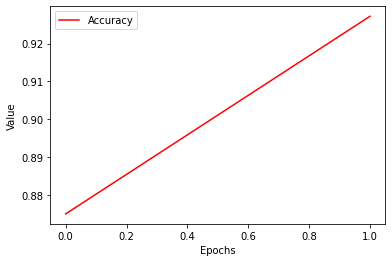

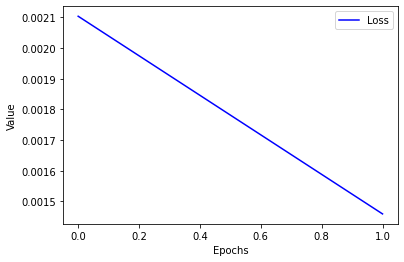

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracy_list, c="red", label ="Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

plt.plot(loss_list, c="blue", label ="Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    words = [torch.tensor(sequence_to_idx(s[0], char_to_idx), dtype=torch.long).to(device) for s in seq]
    sentence = torch.tensor(sequence_to_idx(seq, word_to_idx), dtype=torch.long).to(device)
        
    tag_scores = model(sentence, words)
    _, indices = torch.max(tag_scores, 1)
    ret = []
    for i in range(len(indices)):
        for key, value in tag_to_idx.items():
            if indices[i] == value:
                ret.append((seq[i], key))
    print(ret)